In [42]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [45]:
import SimpleITK as sitk
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import tensorflow as tf

In [44]:
# adc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/1ADC_ss'
adc_folder_path = 'BONBID2023_Train/1ADC_ss'
adc_files = [os.path.join(adc_folder_path, f) for f in os.listdir(adc_folder_path) if f.endswith('.mha')]
adc_files = sorted(adc_files)

In [46]:
# zadc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/2Z_ADC'
zadc_folder_path = 'BONBID2023_Train/2Z_ADC'
zadc_files = [os.path.join(zadc_folder_path, f) for f in os.listdir(zadc_folder_path) if f.endswith('.mha')]
zadc_files = sorted(zadc_files)

In [47]:
# label_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/3LABEL'
label_folder_path = 'BONBID2023_Train/3LABEL'
label_files = [os.path.join(label_folder_path, f) for f in os.listdir(label_folder_path) if f.endswith('.mha')]
label_files = sorted(label_files)

# **Read and display data**

Read and display ADC data

In [48]:
adc_data = []
adc_stik_data = []
for file in adc_files:
    image = sitk.ReadImage(file)
    adc_stik_data.append(image)
    array = sitk.GetArrayFromImage(image)
    adc_data.append(array)

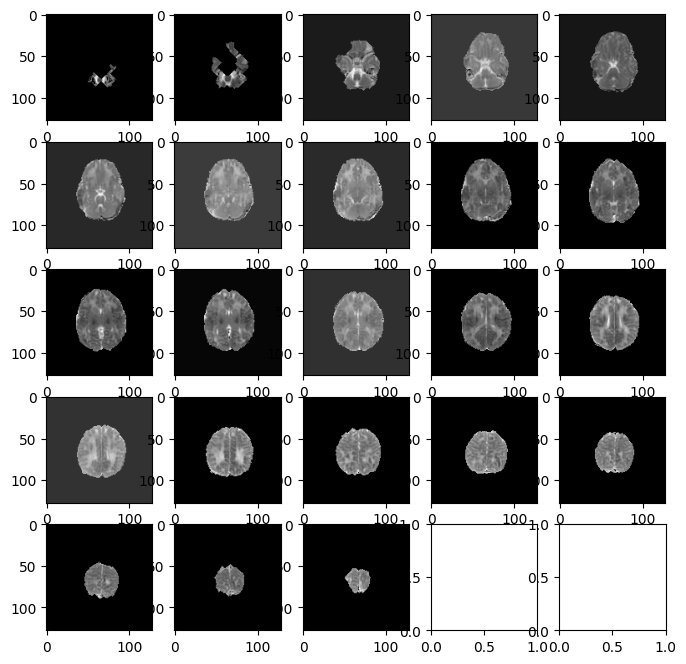

In [49]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < adc_data[0].shape[0]:
        ax.imshow(adc_data[0][i], cmap='gray')

Read and display Zadc data

In [50]:
zadc_data = []
for file in zadc_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    zadc_data.append(array)

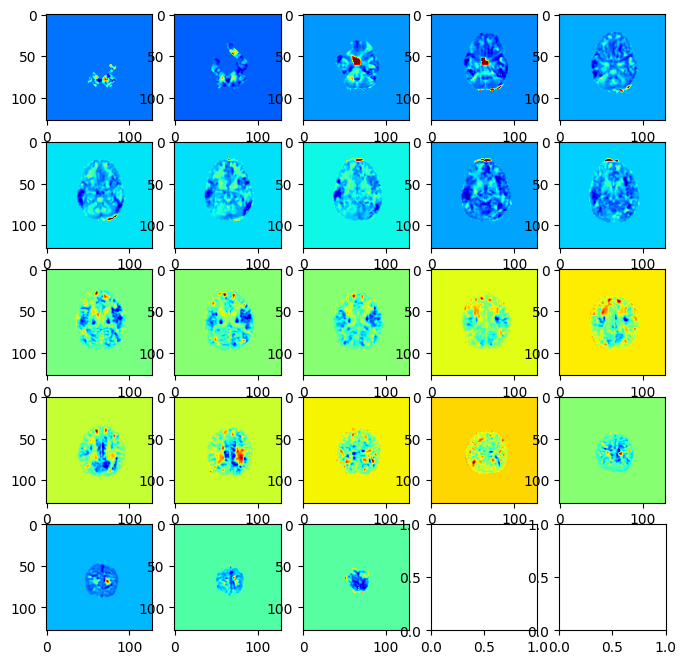

In [51]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < zadc_data[0].shape[0]:
        ax.imshow(zadc_data[0][i], cmap="jet")

Read and display label data

In [52]:
label_data = []
for file in label_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    label_data.append(array)

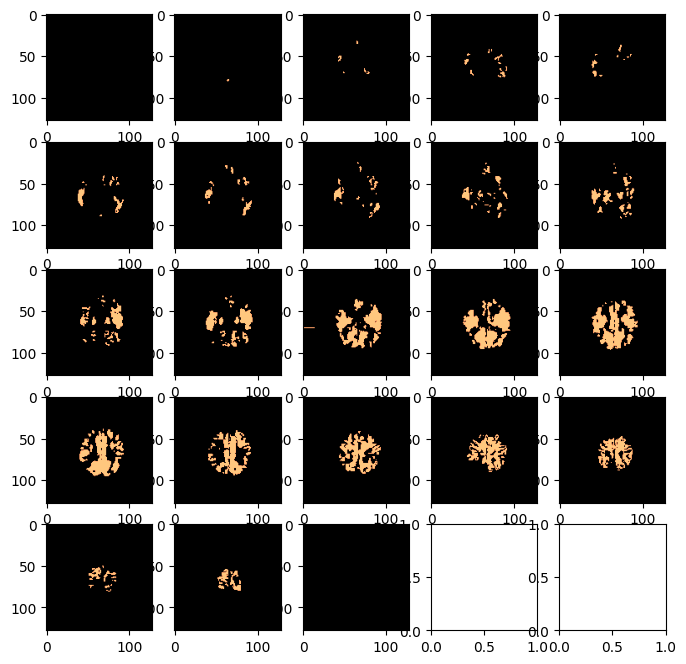

In [53]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < label_data[0].shape[0]:
        ax.imshow(label_data[0][i], cmap="copper")

# **Ready data for training**

In [58]:
# Flatten a list of data with n length and (m, 128, 128) shape of each array, so it becomes a list of n*m of arrays of shape (128, 128)

flattened_adc_data = [item for sublist in adc_data for item in sublist]
flattened_zadc_data = [item for sublist in zadc_data for item in sublist]
flattened_label_data = [item for sublist in label_data for item in sublist]


In [59]:
def crop_center(image, crop_size=(128, 128)):
    height, width = image.shape
    new_height, new_width = crop_size

    start_x = width // 2 - new_width // 2
    start_y = height // 2 - new_height // 2

    return image[start_y:start_y + new_height, start_x:start_x + new_width]

In [60]:
flattened_cropped_zadc_data_list = [crop_center(image, crop_size=(128, 128)) for image in flattened_zadc_data]
flattened_cropped_label_data_list = [crop_center(image, crop_size=(128, 128)) for image in flattened_label_data]

In [61]:
# Convert the list of arrays to a single NumPy array
flattened_cropped_zadc_data = np.array(flattened_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_cropped_zadc_data = flattened_cropped_zadc_data.reshape((len(flattened_cropped_zadc_data_list), 128, 128, 1))

# Print the shape to verify
print(flattened_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_cropped_label_data = np.array(flattened_cropped_label_data_list)
flattened_cropped_label_data = flattened_cropped_label_data.reshape((len(flattened_cropped_label_data_list), 128, 128, 1))

# Print the shape to verify
print(flattened_cropped_label_data.shape)

(3206, 128, 128, 1)
(3206, 128, 128, 1)


# **U Net modified**

In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.metrics import MeanIoU
from keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def unet_model(input_size=(128, 128, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import os

# Define paths
checkpoint_dir = '/UNet'
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.keras')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')], key=os.path.getctime, default=None)
log_filepath = 'training_log.csv'

# Create the CSVLogger
csv_logger = CSVLogger(log_filepath, append=True)

# ModelCheckpoint callback to save the model
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

In [19]:
# Compile the model
model = unet_model()
model.compile(optimizer=SGD(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', MeanIoU(num_classes=2)])

# Load model from the last checkpoint if it exists
if latest_checkpoint is not None:
    model = load_model(latest_checkpoint)
    print(f"Loaded model from {latest_checkpoint}")

# Summary of the model
model.summary()

ValueError: Unknown loss function: dice_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=total_epochs, initial_epoch=initial_epoch, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])

Epoch 1/100
161/161 [==============================] - 130s 611ms/step - loss: 0.9406 - accuracy: 0.5985 - mean_io_u: 0.4898 - val_loss: 0.9311 - val_accuracy: 0.9293 - val_mean_io_u: 0.4857
Epoch 2/100
161/161 [==============================] - 88s 545ms/step - loss: 0.9363 - accuracy: 0.6091 - mean_io_u: 0.4898 - val_loss: 0.9237 - val_accuracy: 0.6262 - val_mean_io_u: 0.4857
Epoch 3/100
161/161 [==============================] - 87s 543ms/step - loss: 0.9338 - accuracy: 0.6174 - mean_io_u: 0.4899 - val_loss: 0.9148 - val_accuracy: 0.5229 - val_mean_io_u: 0.4857
Epoch 4/100
161/161 [==============================] - 88s 544ms/step - loss: 0.9305 - accuracy: 0.6262 - mean_io_u: 0.4900 - val_loss: 0.9005 - val_accuracy: 0.6491 - val_mean_io_u: 0.4858
Epoch 5/100
161/161 [==============================] - 90s 562ms/step - loss: 0.9291 - accuracy: 0.6332 - mean_io_u: 0.4901 - val_loss: 0.8991 - val_accuracy: 0.6520 - val_mean_io_u: 0.4863
Epoch 6/100
161/161 [============================

ResourceExhaustedError: Graph execution error:

Detected at node 'GatherV2_1' defined at (most recent call last):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Windows\Temp\ipykernel_28872\3359081559.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=total_epochs, initial_epoch=initial_epoch, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1096, in compute_metrics
      result = metric.result()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\metrics_utils.py", line 137, in decorated
      raw_result = result_fn(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\base_metric.py", line 162, in result_fn
      return ag_result(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\metrics.py", line 2871, in result
      denominator = tf.gather(denominator, self.target_class_ids)
Node: 'GatherV2_1'
Detected at node 'GatherV2_1' defined at (most recent call last):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Windows\Temp\ipykernel_28872\3359081559.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=total_epochs, initial_epoch=initial_epoch, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1096, in compute_metrics
      result = metric.result()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\metrics_utils.py", line 137, in decorated
      raw_result = result_fn(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\base_metric.py", line 162, in result_fn
      return ag_result(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\metrics.py", line 2871, in result
      denominator = tf.gather(denominator, self.target_class_ids)
Node: 'GatherV2_1'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,128,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_1}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/else/_1/confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert/data_0/_22]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,128,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_1}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4085]

In [ ]:
# # Combine histories
# for key in initial_history.keys():
#     initial_history[key] += history.history[key]

# # Save the combined history
# with open(history_filepath, 'wb') as f:
#     pickle.dump(initial_history, f)

In [ ]:
# Load the training history from CSV
import pandas as pd

history_df = pd.read_csv(csv_logger_path)

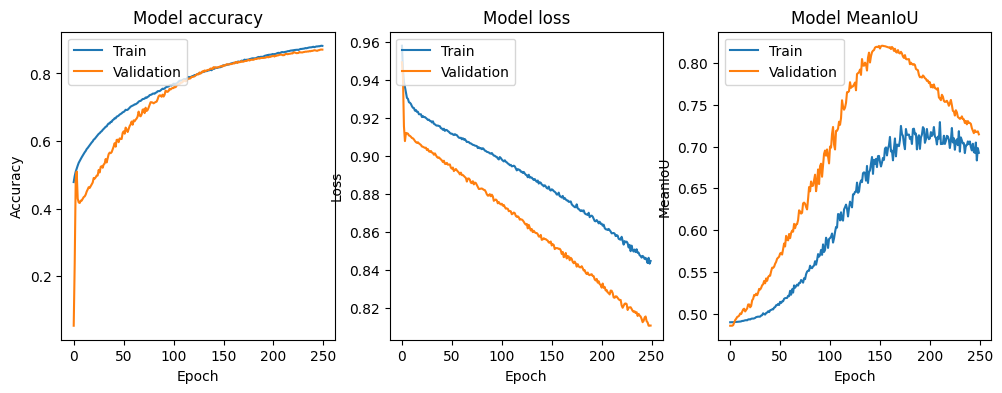

In [ ]:
# Plot training & validation accuracy, loss, and MeanIoU values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u_1'])
plt.plot(history.history['val_mean_io_u_1'])
plt.title('Model MeanIoU')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 [==============================] - 0s 73ms/step


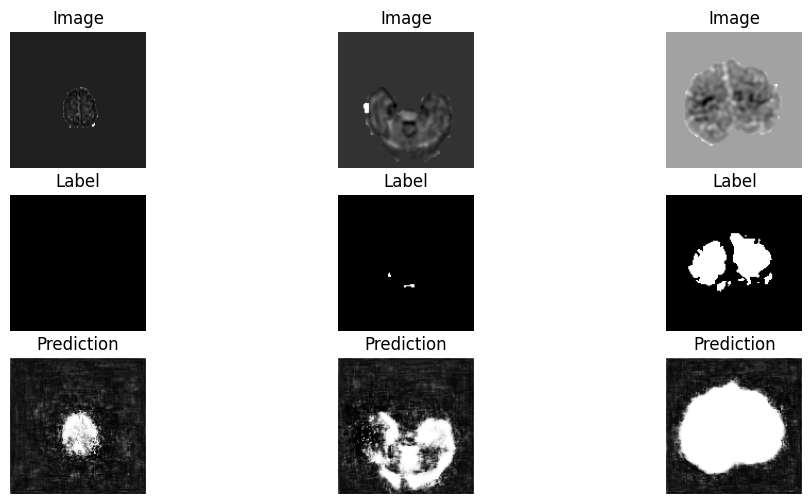

In [ ]:
images = X_val[10:13]
labels = y_val[10:13]

# Get model predictions on a few samples
predictions = model.predict(images)

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(128, 128), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(images, labels, predictions)


# **U Net**

In [67]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized


1 Physical GPUs, 1 Logical GPUs


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.metrics import MeanIoU
from keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def unet_model(input_size=(128, 128, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanIoU
import pickle
import matplotlib.pyplot as plt
import os

# Paths for saving model and history
model_checkpoint_filepath = '/UNet/model_checkpoint_epoch_{epoch:02d}.keras'
history_filepath = 'training_history.pkl'
log_filepath = 'training_log.csv'
initial_epoch = 0
total_epochs = 100

# Define callbacks
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

csv_logger = CSVLogger(log_filepath, append=True)

In [ ]:
# Compile the model
model = unet_model()
model.compile(optimizer=SGD(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', MeanIoU(num_classes=2)])

# Load previous history if it exists
if os.path.exists(history_filepath):
    with open(history_filepath, 'rb') as f:
        initial_history = pickle.load(f)
    initial_epoch = len(initial_history['accuracy'])
else:
    initial_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'mean_io_u': [], 'val_mean_io_u': []}

# Summary of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=total_epochs, initial_epoch=initial_epoch, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])

Epoch 1/100
161/161 [==============================] - 93s 548ms/step - loss: 0.9396 - accuracy: 0.5215 - mean_io_u_2: 0.4898 - val_loss: 0.9264 - val_accuracy: 0.8855 - val_mean_io_u_2: 0.4857
Epoch 2/100
161/161 [==============================] - 85s 528ms/step - loss: 0.9346 - accuracy: 0.5322 - mean_io_u_2: 0.4899 - val_loss: 0.8733 - val_accuracy: 0.8568 - val_mean_io_u_2: 0.4857
Epoch 3/100
161/161 [==============================] - 84s 521ms/step - loss: 0.9333 - accuracy: 0.5396 - mean_io_u_2: 0.4899 - val_loss: 0.8858 - val_accuracy: 0.7541 - val_mean_io_u_2: 0.4857
Epoch 4/100
161/161 [==============================] - 84s 521ms/step - loss: 0.9305 - accuracy: 0.5467 - mean_io_u_2: 0.4900 - val_loss: 0.8922 - val_accuracy: 0.6734 - val_mean_io_u_2: 0.4857
Epoch 5/100
161/161 [==============================] - 83s 513ms/step - loss: 0.9286 - accuracy: 0.5537 - mean_io_u_2: 0.4901 - val_loss: 0.9022 - val_accuracy: 0.5545 - val_mean_io_u_2: 0.4866
Epoch 6/100
161/161 [=========

ResourceExhaustedError: Graph execution error:

Detected at node 'GatherV2_1' defined at (most recent call last):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Windows\Temp\ipykernel_32420\3359081559.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=total_epochs, initial_epoch=initial_epoch, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1096, in compute_metrics
      result = metric.result()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\metrics_utils.py", line 137, in decorated
      raw_result = result_fn(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\base_metric.py", line 162, in result_fn
      return ag_result(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\metrics.py", line 2871, in result
      denominator = tf.gather(denominator, self.target_class_ids)
Node: 'GatherV2_1'
Detected at node 'GatherV2_1' defined at (most recent call last):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Windows\Temp\ipykernel_32420\3359081559.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=total_epochs, initial_epoch=initial_epoch, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1096, in compute_metrics
      result = metric.result()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\metrics_utils.py", line 137, in decorated
      raw_result = result_fn(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\base_metric.py", line 162, in result_fn
      return ag_result(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\metrics\metrics.py", line 2871, in result
      denominator = tf.gather(denominator, self.target_class_ids)
Node: 'GatherV2_1'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,128,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_1}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[16,128,128,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_1}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_326687]

In [ ]:
# Combine histories
for key in initial_history.keys():
    initial_history[key] += history.history[key]

# Save the combined history
with open(history_filepath, 'wb') as f:
    pickle.dump(initial_history, f)

In [ ]:
# Plot training & validation accuracy, loss, and MeanIoU values
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(initial_history['accuracy'])
plt.plot(initial_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(initial_history['loss'])
plt.plot(initial_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(initial_history['mean_io_u'])
plt.plot(initial_history['val_mean_io_u'])
plt.title('Model MeanIoU')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

: 

In [ ]:
images = X_val[:3]
labels = y_val[:3]

# Get model predictions on a few samples
predictions = model.predict(images)

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(128, 128), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(images, labels, predictions)

: 